<a href="https://colab.research.google.com/github/Dreadnought73/AI_projects/blob/main/Sentiment_analysis_ALBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with ALBERT

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification, AlbertConfig
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [ ]:
finance = pd.read_csv('/content/drive/MyDrive/Coding_data_files/finance_sentiment_analysis.csv', encoding='latin-1')
finance.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


Setting new columns for easier accessibility during the development.

In [ ]:
finance.columns = ['Sentiment', 'Text']

In [ ]:
finance.head()

,Sentiment,Text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


The neutral category has an overwhelming majority compared to the other categories.

In [ ]:
finance['Sentiment'].value_counts()

,count
Sentiment,
neutral,2878
positive,1363
negative,604


In [ ]:
label_encoder = LabelEncoder()
finance['encoded_sentiments'] = label_encoder.fit_transform(finance['Sentiment'])

# Map encoded labels back to sentiment names for reference
# This creates a dictionary to easily look up the sentiment name from the encoded integer
encoded_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"Encoded labels mapping: {encoded_to_label}")

Encoded labels mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    finance['Text'],
    finance['encoded_sentiments'],
    test_size=.2,
    random_state=42,
    stratify=finance['encoded_sentiments']
)

print(f"\nLoading ALBERT tokenizer and model: {'albert-base-v2'}")
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

config = AlbertConfig.from_pretrained('albert-base-v2', num_labels=3)
model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', config=config)


Loading ALBERT tokenizer and model: albert-base-v2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This is to find the optimal max_seq_length for the final tokenizer

In [ ]:
encoded_inputs = tokenizer(
    list(finance['Text'].values),
    truncation=False,
    padding=False,
    return_attention_mask=False,
    return_token_type_ids=False,
    return_tensors=None
)

token_lengths = [len(input_ids) for input_ids in encoded_inputs['input_ids']]

print(f"Calculated lengths for {len(token_lengths)} sentences.")

Calculated lengths for 4845 sentences.


Finding out where most the current sentences end to know what max_length to set.

In [ ]:
print("\nAnalyzing token length distribution:")
print(f"  Min Length: {np.min(token_lengths)}")
print(f"  Max Length: {np.max(token_lengths)}")
print(f"  Mean Length: {np.mean(token_lengths):.2f}")
print(f"  Median Length: {np.median(token_lengths)}")


percentiles = [90, 95, 99]
for p in percentiles:
    length = np.percentile(token_lengths, p)
    print(f"  {p}th Percentile Length: {length:.2f}")


Analyzing token length distribution:
  Min Length: 5
  Max Length: 195
  Mean Length: 33.64
  Median Length: 31.0
  90th Percentile Length: 55.00
  95th Percentile Length: 63.00
  99th Percentile Length: 77.00


Tokenizing the train and test set and creating constant tensors.

In [ ]:
train_encoding = tokenizer(
    list(X_train.values),
    truncation=True,
    padding=True,
    max_length=63,
    return_tensors='tf'
)

test_encoding = tokenizer(
    list(X_test.values),
    truncation=True,
    padding=True,
    max_length=63,
    return_tensors='tf'
)

y_train_tf = tf.constant(y_train.values)
y_test_tf = tf.constant(y_test.values)

Building and training the model.

In [ ]:
import tensorflow.compat.v1 as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # loss function
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy') # defining the metrics for evaluation
model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # putting everything together

In [ ]:
# it pairs up each sentence's tokenized encodings (as a dictionary) with its corresponding label (tf.data.Dataset.from_tensor_slices)
print("\nFinetuning the ALBERT model...")

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encoding), # dictionary containing tensors like input_ids, attention_masks:
                          # Each "slice" from this will be a dictionary containing one sequence of input IDs, one attention mask, etc., corresponding to a single sentence
    y_train_tf)).batch(24)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encoding), y_test_tf)).batch(24)

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset
    )

print("Model finetuning complete.")


Finetuning the ALBERT model...
Epoch 1/5
162/162 [==============================] - 3144s 19s/step - loss: 0.9599 - accuracy: 0.5795 - val_loss: 0.9398 - val_accuracy: 0.5944
Epoch 2/5
162/162 [==============================] - 3134s 19s/step - loss: 0.9708 - accuracy: 0.5779 - val_loss: 0.9327 - val_accuracy: 0.5944
Epoch 3/5
162/162 [==============================] - 3124s 19s/step - loss: 0.9721 - accuracy: 0.5761 - val_loss: 0.9288 - val_accuracy: 0.5944
Epoch 4/5
162/162 [==============================] - 3135s 19s/step - loss: 0.9734 - accuracy: 0.5740 - val_loss: 0.9302 - val_accuracy: 0.5944
Epoch 5/5
162/162 [==============================] - 3139s 19s/step - loss: 0.9710 - accuracy: 0.5766 - val_loss: 0.9299 - val_accuracy: 0.5944
Model finetuning complete.


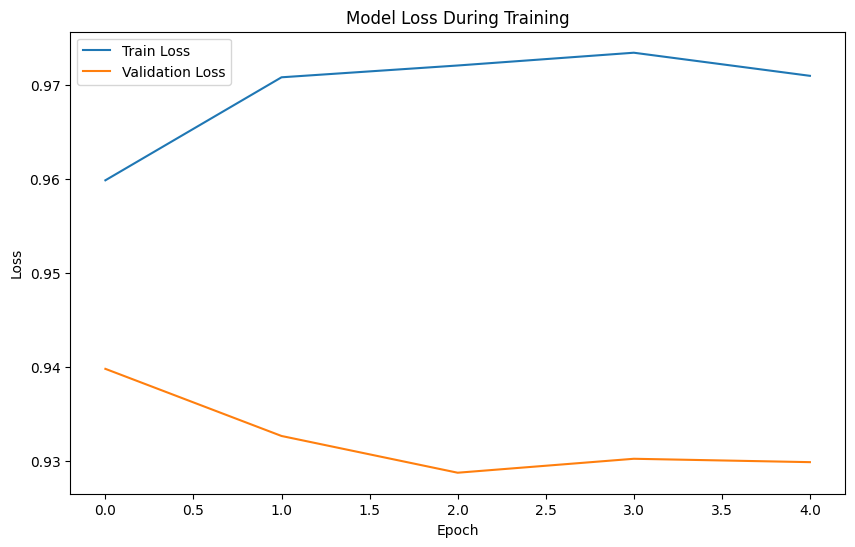

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

41/41 [==============================] - 253s 6s/step - loss: 0.9299 - accuracy: 0.5944
Test Loss: 0.9299
Test Accuracy: 0.5944


In [ ]:
sample_sentences = [
    "The stock market saw mixed movements this week as investors digested recent economic data. Trading volume remained moderate across major exchanges.",
    "Strong job growth numbers indicate a strengthening economy. This is a positive sign for future economic expansion.",
    "Supply chain disruptions continue to weigh on manufacturing output. This could impact inventory levels and consumer prices.",
    "Inflation figures were released today, showing a slight change from the previous month. Analysts are considering the potential impact on consumer spending.",
    "Several companies reported better-than-expected earnings this quarter. This performance is boosting confidence in those sectors.",
    "Geopolitical tensions are creating uncertainty in global markets. Investors are showing caution due to increased risks.",
    "A key economic indicator showed a contraction in the last quarter. This has raised concerns about the pace of economic recovery.",
    "Market sentiment improved today with a broad rally across technology stocks. Innovation continues to drive growth in the sector.",
    "The central bank announced its decision on interest rates this afternoon. Rates will remain unchanged for the current period."
]

sample_encodings = tokenizer(
    sample_sentences,
    truncation=True,
    padding=True,
    max_length=70,
    return_tensors='tf'
)

predictions = model.predict(dict(sample_encodings))

predicted_logits = predictions.logits
predicted_classes = tf.argmax(predicted_logits, axis=1).numpy() # Get the index of the highest logit

# Convert predicted class indices back to sentiment labels
predicted_sentiments = [encoded_to_label[class_idx] for class_idx in predicted_classes]

for sentence, sentiment in zip(sample_sentences, predicted_sentiments):
    print(f"Sentence: '{sentence}' -> Predicted Sentiment: {sentiment}")

1/1 [==============================] - 5s 5s/step
Sentence: 'The stock market saw mixed movements this week as investors digested recent economic data. Trading volume remained moderate across major exchanges.' -> Predicted Sentiment: neutral
Sentence: 'Strong job growth numbers indicate a strengthening economy. This is a positive sign for future economic expansion.' -> Predicted Sentiment: neutral
Sentence: 'Supply chain disruptions continue to weigh on manufacturing output. This could impact inventory levels and consumer prices.' -> Predicted Sentiment: neutral
Sentence: 'Inflation figures were released today, showing a slight change from the previous month. Analysts are considering the potential impact on consumer spending.' -> Predicted Sentiment: neutral
Sentence: 'Several companies reported better-than-expected earnings this quarter. This performance is boosting confidence in those sectors.' -> Predicted Sentiment: neutral
Sentence: 'Geopolitical tensions are creating uncertainty 

**After handling class imbalance, we could receive probbaly a better result.**